## Predictive Analysis using scikit-learn

In [1]:
# import modules
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# load the data set
mr_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data", header = None)

#### 1. Create a dataframe with a subset of the columns that includes the 'edible/poisonous', 'odor', 'cap-color', 'gill-color', 'gill-spacing', and 'gill-size' columns.

In [2]:
# create a subset of 6 columns, including 'edible' / 'poisonous'
# use the 'copy()' function if you want to preserve the original data frame
mr_sub = mr_df.iloc[:, [0, 5, 3, 9, 7, 8]].copy()

In [3]:
# check results: Check the first 10 rows
mr_sub.head(10)

,0,5,3,9,7,8
0,p,p,n,k,c,n
1,e,a,y,k,c,b
2,e,l,w,n,c,b
3,p,p,w,n,c,n
4,e,n,g,k,w,b
5,e,a,y,n,c,b
6,e,a,w,g,c,b
7,e,l,w,n,c,b
8,p,p,w,p,c,n
9,e,a,y,g,c,b


#### 2. Add meaningful column names

In [4]:
# add meaningful column names
mr_sub.columns = ['Poisonous', 'Odor', 'Cap_Color', 'Gill_Color', 'Gill_Spacing', 'Gill_Size']
# sanity check
mr_sub.head(5)

,Poisonous,Odor,Cap_Color,Gill_Color,Gill_Spacing,Gill_Size
0,p,p,n,k,c,n
1,e,a,y,k,c,b
2,e,l,w,n,c,b
3,p,p,w,n,c,n
4,e,n,g,k,w,b


#### 3. Convert the “e”/”p” indicators in the first column to digits; Replace the single letter abbreviations used in the data with more descriptive character strings

In [5]:
# replace Edible col values
mr_sub.Poisonous.replace('e', 0, inplace = True)
mr_sub.Poisonous.replace('p', 1, inplace = True)

# replace Cap color col values
mr_sub.Cap_Color.replace({'n': 'brown', 
                          'b': 'buff',
                          'c': 'cinnamon',
                          'g': 'gray',
                          'r': 'green',
                          'p': 'pink',
                          'u': 'purple',
                          'e': 'red',
                          'w': 'white',
                          'y': 'yellow'}, inplace = True)
                            
# replace Odor col values
mr_sub.Odor.replace({'a': 'almond', 
                     'l': 'anise',
                     'c': 'creosote',
                     'y': 'fishy',
                     'f': 'foul',
                     'm': 'musty',
                     'n': 'none',
                     'p': 'pungent',
                     's': 'spicy'}, inplace = True)

# replace Gill-color col values
mr_sub.Gill_Color.replace({'k': 'black',
                           'n': 'brown',
                           'b': 'buff',
                           'h': 'chocolate',
                           'g': 'gray',
                           'r': 'green',
                           'o': 'orange',
                           'p': 'pink',
                           'u': 'purple',
                           'e': 'red',
                           'w': 'white',
                           'y': 'yellow'}, inplace = True)

# replace Gill-spacing col values
mr_sub.Gill_Spacing.replace({'c': 'close',
                             'w': 'crowded',
                             'd': 'distant'}, inplace = True)

# replace Gill-size col values
mr_sub.Gill_Size.replace({'b': 'broad',
                          'n': 'narrow'}, inplace = True)
mr_sub.head(5)

,Poisonous,Odor,Cap_Color,Gill_Color,Gill_Spacing,Gill_Size
0,1,pungent,brown,black,close,narrow
1,0,almond,yellow,black,close,broad
2,0,anise,white,brown,close,broad
3,1,pungent,white,brown,close,narrow
4,0,none,gray,black,crowded,broad


4. Use get_dummies function to create dummy variables.

In [6]:
# create dummy variables for cols except Poisonous col.
mr_dm = pd.get_dummies(mr_sub)
mr_dm.columns

Index(['Poisonous', 'Odor_almond', 'Odor_anise', 'Odor_creosote', 'Odor_fishy',
       'Odor_foul', 'Odor_musty', 'Odor_none', 'Odor_pungent', 'Odor_spicy',
       'Cap_Color_brown', 'Cap_Color_buff', 'Cap_Color_cinnamon',
       'Cap_Color_gray', 'Cap_Color_green', 'Cap_Color_pink',
       'Cap_Color_purple', 'Cap_Color_red', 'Cap_Color_white',
       'Cap_Color_yellow', 'Gill_Color_black', 'Gill_Color_brown',
       'Gill_Color_buff', 'Gill_Color_chocolate', 'Gill_Color_gray',
       'Gill_Color_green', 'Gill_Color_orange', 'Gill_Color_pink',
       'Gill_Color_purple', 'Gill_Color_red', 'Gill_Color_white',
       'Gill_Color_yellow', 'Gill_Spacing_close', 'Gill_Spacing_crowded',
       'Gill_Size_broad', 'Gill_Size_narrow'],
      dtype='object')

#### 4. EDA

Checking for nulls:

In [7]:
mr_sub.columns[mr_sub.isnull().any()]

Index([], dtype='object')

In [8]:
mr_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 6 columns):
Poisonous       8124 non-null int64
Odor            8124 non-null object
Cap_Color       8124 non-null object
Gill_Color      8124 non-null object
Gill_Spacing    8124 non-null object
Gill_Size       8124 non-null object
dtypes: int64(1), object(5)
memory usage: 380.9+ KB


Checked for nulls and missing values. Based on the results above, the dataset does not contain any nulls or missing values. At this point, the number of use cases for the analysis and for all attributes is still the same at 8124.

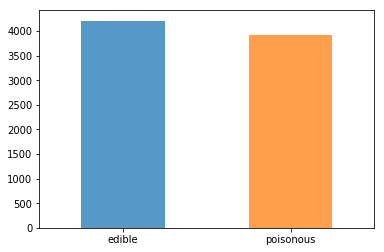

In [11]:
# matplotlib graph of Edible / Poisonous
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# create a new dataset of edible col
Poisonous=mr_sub.Poisonous

# replace Edible col values
Poisonous.replace(0, 'edible',inplace = True)
Poisonous.replace(1, 'poisonous', inplace = True)

# plot edible variables in bar chart
df = Poisonous.value_counts()
df.plot(kind='bar',alpha=0.75, rot=0)
plt.show()

Discussion of Result: Based on the counts for each group this bar chart just confirms that the edible mashroom number is slightly higher than the number of poisonouse ones in the dataset.

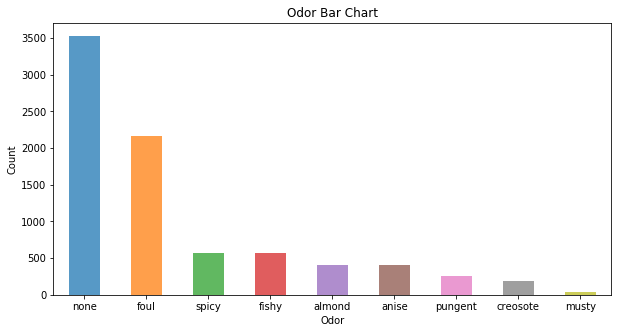

In [12]:
# create a new dataset of odor col
odor = mr_sub.Odor

# define a new figure for plotting
plt.figure(figsize=(10,5))

# give the plot a title
plt.title('Odor Bar Chart')
plt.xlabel('Odor')
plt.ylabel('Count')

# plot in bar chart
odor_c = odor.value_counts().sort_values(ascending = False)
odor_c.plot(kind='bar',alpha=0.75, rot=0)
plt.show()

Discussion of Result: Based on the counts for each group this bar chart, the biggest distribuion of odor for this dataset is none then the second is the foul and the count is hughly higher than that of the rest in the dataset.

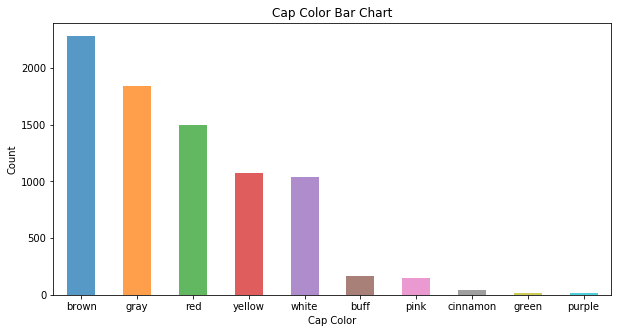

In [13]:
# create a new dataset of Cap_Color col
cap_color = mr_sub.Cap_Color

# define a new figure for plotting
plt.figure(figsize=(10,5))

# give the plot a title
plt.title('Cap Color Bar Chart')
plt.xlabel('Cap Color')
plt.ylabel('Count')

# plot in bar chart
cap_color_c = cap_color.value_counts().sort_values(ascending = False)
cap_color_c.plot(kind='bar',alpha=0.75, rot=0)
plt.show()

Discussion of Result: Based on the counts for each group this bar chart, the biggest distribuion of cap color for this dataset is brown then the second is the gray. The followings are red, yellow, white, buff, pink, cinnamon, purple and green.

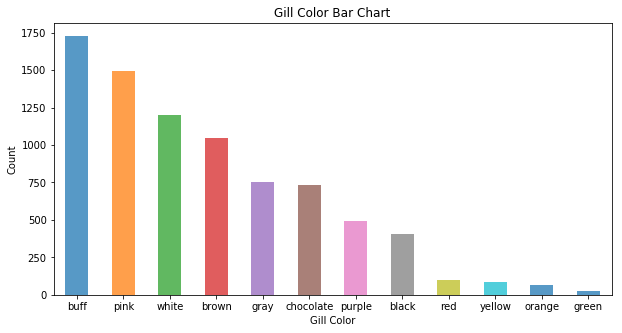

In [14]:
# create a new dataset of Gill_Color col
gill_color = mr_sub.Gill_Color

# define a new figure for plotting
plt.figure(figsize=(10,5))

# give the plot a title
plt.title('Gill Color Bar Chart')
plt.xlabel('Gill Color')
plt.ylabel('Count')

# plot in bar chart
gill_color_c = gill_color.value_counts().sort_values(ascending = False)
gill_color_c.plot(kind='bar',alpha=0.75, rot=0)
plt.show()

Discussion of Result: Based on the counts for each group this bar chart, the biggest distribuion of gill color for this dataset is buff then the second is the pink. The followings are white, brown, gray, chocolate, purple, black, red, yellow, orange, and green.

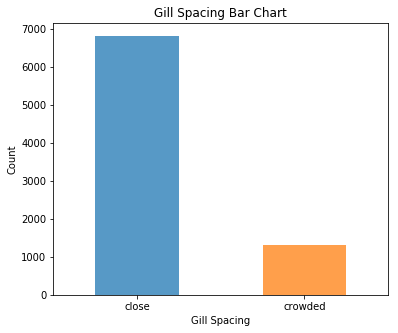

In [15]:
# create a new dataset of Gill_Spacing col
gill_spacing = mr_sub.Gill_Spacing

# define a new figure for plotting
plt.figure(figsize=(6,5))

# give the plot a title
plt.title('Gill Spacing Bar Chart')
plt.xlabel('Gill Spacing')
plt.ylabel('Count')

# plot in bar chart
gill_spacing_c = gill_spacing.value_counts().sort_values(ascending = False)
gill_spacing_c.plot(kind='bar',alpha=0.75, rot=0)
plt.show()

Discussion of Result: Based on the counts for each group this bar chart, gill spacing column includes two types of values, which are close and crowded. And the count of close is far beyond that of crowded.

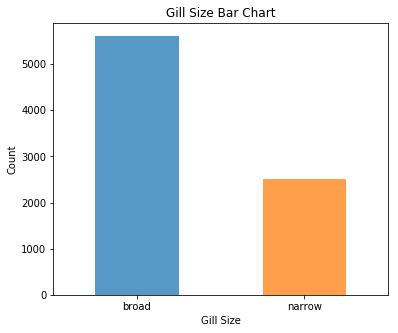

In [16]:
# create a new dataset of Gill_Size col
gill_size = mr_sub.Gill_Size

# define a new figure for plotting
plt.figure(figsize=(6,5))

# give the plot a title
plt.title('Gill Size Bar Chart')
plt.xlabel('Gill Size')
plt.ylabel('Count')

# plot in bar chart
gill_size_c = gill_size.value_counts().sort_values(ascending = False)
gill_size_c.plot(kind='bar',alpha=0.75, rot=0)
plt.show()

Discussion of Result: Based on the counts for each group this bar chart, gill size column includes two types of values, which are broad and narrow. And the count of broad is nearly two times as that of crowded.

In [17]:
# build plot for edible/poisonous vs. odor
mr1 = mr_sub.iloc[:, [0, 1]].copy()
mr1.head(5)

,Poisonous,Odor
0,poisonous,pungent
1,edible,almond
2,edible,anise
3,poisonous,pungent
4,edible,none


In [18]:
# group by odor and edible, then count frequency of each division
dt1 = mr1.groupby(by = ['Odor','Poisonous']).size().unstack()
dt1

Poisonous,edible,poisonous
Odor,,
almond,400.0,NaN
anise,400.0,NaN
creosote,NaN,192.0
fishy,NaN,576.0
foul,NaN,2160.0
musty,NaN,36.0
none,3408.0,120.0
pungent,NaN,256.0
spicy,NaN,576.0


Text(0.5, 1.0, 'Edible/Poisonous vs. Odor Bar Chart')

<Figure size 720x360 with 0 Axes>

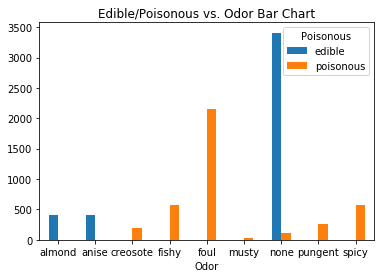

In [19]:
# build a bar plot
plt.figure(figsize=(10,5)) # set the figure size
dt1.plot.bar(rot=0) # rotate x-bar label to 0 degree
plt.title('Edible/Poisonous vs. Odor Bar Chart') # assign a title

In [20]:
# build plot for edible/poisonous vs. Cap_Color
mr2 = mr_sub.iloc[:, [0, 2]].copy()
mr2.head(5)

,Poisonous,Cap_Color
0,poisonous,brown
1,edible,yellow
2,edible,white
3,poisonous,white
4,edible,gray


In [22]:
# group by odor and cap color, then count frequency of each division
dt2 = mr2.groupby(by = ['Cap_Color','Poisonous']).size().unstack()
dt2.head(5)

Poisonous,edible,poisonous
Cap_Color,,
brown,1264.0,1020.0
buff,48.0,120.0
cinnamon,32.0,12.0
gray,1032.0,808.0
green,16.0,NaN


Text(0.5, 1.0, 'Edible/Poisonous vs. Cap Color Bar Chart')

<Figure size 720x360 with 0 Axes>

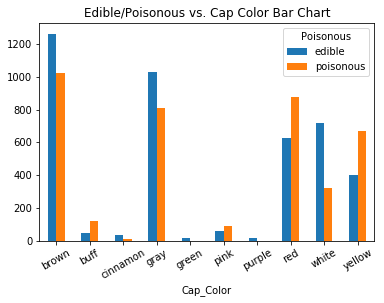

In [23]:
# build a bar plot
plt.figure(figsize=(10,5)) # set the figure size
dt2.plot.bar(rot=30) # rotate x-bar label to 0 degree
plt.title('Edible/Poisonous vs. Cap Color Bar Chart') # assign a title

In [24]:
# build plot for edible/poisonous vs. Gill_Color
mr3 = mr_sub.iloc[:, [0, 3]].copy()
mr3.head(5)

,Poisonous,Gill_Color
0,poisonous,black
1,edible,black
2,edible,brown
3,poisonous,brown
4,edible,black


In [25]:
# group by odor and gill color, then count frequency of each division
dt3 = mr3.groupby(by = ['Gill_Color','Poisonous']).size().unstack()
dt3.head(5)

Poisonous,edible,poisonous
Gill_Color,,
black,344.0,64.0
brown,936.0,112.0
buff,NaN,1728.0
chocolate,204.0,528.0
gray,248.0,504.0


Text(0.5, 1.0, 'Edible/Poisonous vs. Gill Color Bar Chart')

<Figure size 720x360 with 0 Axes>

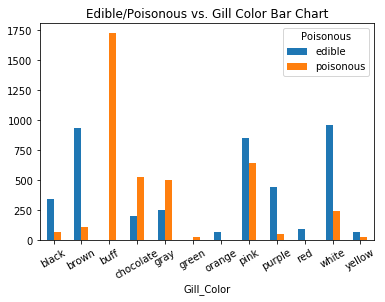

In [26]:
# build a bar plot
plt.figure(figsize=(10,5)) # set the figure size
dt3.plot.bar(rot=30) # rotate x-bar label to 0 degree
plt.title('Edible/Poisonous vs. Gill Color Bar Chart') # assign a title

In [27]:
# build plot for edible/poisonous vs. Gill_Spacing
mr4 = mr_sub.iloc[:, [0, 4]].copy()
mr4.head(5)

,Poisonous,Gill_Spacing
0,poisonous,close
1,edible,close
2,edible,close
3,poisonous,close
4,edible,crowded


In [28]:
# group by odor and gill spacing, then count frequency of each division
dt4 = mr4.groupby(by = ['Gill_Spacing','Poisonous']).size().unstack()
dt4.head(5)

Poisonous,edible,poisonous
Gill_Spacing,,
close,3008,3804
crowded,1200,112


Text(0.5, 1.0, 'Edible/Poisonous vs. Gill Spacing Bar Chart')

<Figure size 720x360 with 0 Axes>

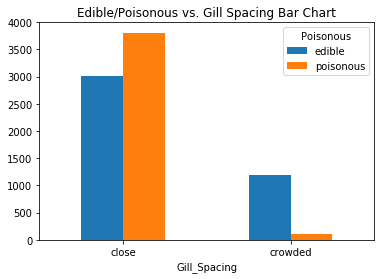

In [29]:
# build a bar plot
plt.figure(figsize=(10,5)) # set the figure size
dt4.plot.bar(rot=0) # rotate x-bar label to 0 degree
plt.title('Edible/Poisonous vs. Gill Spacing Bar Chart') # assign a title

In [30]:
# build plot for edible/poisonous vs. Gill_Size
mr5 = mr_sub.iloc[:, [0, 5]].copy()
mr5.head(5)

,Poisonous,Gill_Size
0,poisonous,narrow
1,edible,broad
2,edible,broad
3,poisonous,narrow
4,edible,broad


In [31]:
# group by odor and gill spacing, then count frequency of each division
dt5 = mr5.groupby(by = ['Gill_Size','Poisonous']).size().unstack()
dt5.head(5)

Poisonous,edible,poisonous
Gill_Size,,
broad,3920,1692
narrow,288,2224


Text(0.5, 1.0, 'Edible/Poisonous vs. Gill Size Bar Chart')

<Figure size 720x360 with 0 Axes>

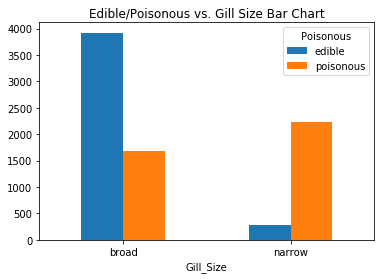

In [32]:
# build a bar plot
plt.figure(figsize=(10,5)) # set the figure size
dt5.plot.bar(rot=0) # rotate x-bar label to 0 degree
plt.title('Edible/Poisonous vs. Gill Size Bar Chart') # assign a title

#### 5. Prepare Data for Logistic Regression

In [33]:
# create dataframes with an intercept column and all dummy variables
y, X = dmatrices('Poisonous ~ Odor_almond + Odor_anise + Odor_creosote + Odor_fishy +\
       Odor_foul + Odor_musty + Odor_none + Odor_pungent + Odor_spicy +\
       Cap_Color_brown + Cap_Color_buff + Cap_Color_cinnamon +\
       Cap_Color_gray + Cap_Color_green + Cap_Color_pink +\
       Cap_Color_purple + Cap_Color_red + Cap_Color_white +\
       Cap_Color_yellow + Gill_Color_black + Gill_Color_brown +\
       Gill_Color_buff + Gill_Color_chocolate + Gill_Color_gray +\
       Gill_Color_green + Gill_Color_orange + Gill_Color_pink +\
       Gill_Color_purple + Gill_Color_red + Gill_Color_white +\
       Gill_Color_yellow + Gill_Spacing_close + Gill_Spacing_crowded +\
       Gill_Size_broad + Gill_Size_narrow',
                  mr_dm, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'Odor_almond', 'Odor_anise', 'Odor_creosote', 'Odor_fishy',
       'Odor_foul', 'Odor_musty', 'Odor_none', 'Odor_pungent', 'Odor_spicy',
       'Cap_Color_brown', 'Cap_Color_buff', 'Cap_Color_cinnamon',
       'Cap_Color_gray', 'Cap_Color_green', 'Cap_Color_pink',
       'Cap_Color_purple', 'Cap_Color_red', 'Cap_Color_white',
       'Cap_Color_yellow', 'Gill_Color_black', 'Gill_Color_brown',
       'Gill_Color_buff', 'Gill_Color_chocolate', 'Gill_Color_gray',
       'Gill_Color_green', 'Gill_Color_orange', 'Gill_Color_pink',
       'Gill_Color_purple', 'Gill_Color_red', 'Gill_Color_white',
       'Gill_Color_yellow', 'Gill_Spacing_close', 'Gill_Spacing_crowded',
       'Gill_Size_broad', 'Gill_Size_narrow'],
      dtype='object')


In [34]:
# flatten y into a 1-D array
y = np.ravel(y)

#### 6. Logistic Regression

In [35]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9901526341703595

99% accuracy seems perfect, but what's the null error rate?

In [36]:
# what percentage is poisonous?
y.mean()

0.48202855736090594

Only 48% of the mushroom was poisonous, which means that you could obtain 48% accuracy by always predicting "poisonous". So we're doing better than the null error rate, but not by much.

In [37]:
# create dataframes with an intercept column, and cap_color dummy variables
y, X = dmatrices('Poisonous ~ Cap_Color_brown + Cap_Color_buff + Cap_Color_cinnamon +\
       Cap_Color_gray + Cap_Color_green + Cap_Color_pink +\
       Cap_Color_purple + Cap_Color_red + Cap_Color_white +\
       Cap_Color_yellow ',
                  mr_dm, return_type="dataframe")

# flatten y into a 1-D array
y = np.ravel(y)

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5952732644017725

#### The accuracy of poisonouse prediction is only 59.5% when using cap_color as indicator.

In [38]:
# create dataframes with an intercept column, and gill_color dummy variables
y, X = dmatrices('Poisonous ~ Gill_Color_black + Gill_Color_brown +\
       Gill_Color_buff + Gill_Color_chocolate + Gill_Color_gray +\
       Gill_Color_green + Gill_Color_orange + Gill_Color_pink +\
       Gill_Color_purple + Gill_Color_red + Gill_Color_white +\
       Gill_Color_yellow',
                  mr_dm, return_type="dataframe")

# flatten y into a 1-D array
y = np.ravel(y)

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8050221565731167

#### The accuracy of poisonouse prediction is as high as 80.5% when using gill_color as indicator.

In [39]:
# create dataframes with an intercept column, and gill_spacing dummy variables
y, X = dmatrices('Poisonous ~ Gill_Spacing_close + Gill_Spacing_crowded',
                  mr_dm, return_type="dataframe")

# flatten y into a 1-D array
y = np.ravel(y)

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6159527326440177

#### The accuracy of poisonouse prediction is only 61.6% when using gill_color as indicator.

In [40]:
# create dataframes with an intercept column, and gill_size dummy variables
y, X = dmatrices('Poisonous ~ Gill_Size_broad + Gill_Size_narrow',
                  mr_dm, return_type="dataframe")

# flatten y into a 1-D array
y = np.ravel(y)

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7562776957163959

#### The accuracy of poisonouse prediction is only 75.6% when using gill_size as indicator.

In [41]:
# create dataframes with an intercept column, and odor dummy variables
y, X = dmatrices('Poisonous ~ Odor_almond + Odor_anise + Odor_creosote + Odor_fishy +\
       Odor_foul + Odor_musty + Odor_none + Odor_pungent + Odor_spicy',
                  mr_dm, return_type="dataframe")

# flatten y into a 1-D array
y = np.ravel(y)

# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

C:\Users\51759\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9852289512555391

#### The accuracy of poisonouse prediction is super high as 98.5% when using odor as indicator.

### Conclusions: 
### 1. From the indicators (including odor, cap color, gill color, gill spacing, and gill size), odor is the most efficient factor to predict poisonous mushroom or not, and it's prediction accuracy is as high as 98.5%. If you are going to choose only one factor for prediction, odor must be the one;
### 2. The second most efficient factor is gill color, whose accuracy is 80.5%; the third one is gill size, 75.6%; the fourth one is gill spacing, 61.6%

### Further analysis: 99% is such a high accuracy for prediction. The next step may be find less than 3 factors, combining with odor, in order to get an accuracy higher than 99.5%.